In [1]:
!kaggle datasets download harishkumardatalab/food-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset
License(s): CC0-1.0
100% 1.68G/1.68G [01:25<00:00, 22.5MB/s]
100% 1.68G/1.68G [01:25<00:00, 21.2MB/s]


In [2]:
import zipfile

import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetV2B0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
with zipfile.ZipFile('food-image-classification-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('food-image-classification-dataset')

In [4]:
!ls 'food-image-classification-dataset/Food Classification dataset'

 apple_pie	 cheesecake	   Donut        jalebi	       omelette     Sandwich
'Baked Potato'	 chicken_curry	   fried_rice   kaathi_rolls   paani_puri   sushi
 burger		 chole_bhature	   Fries        kadai_paneer   pakode	    Taco
 butter_naan	'Crispy Chicken'  'Hot Dog'     kulfi	       pav_bhaji    Taquito
 chai		 dal_makhani	   ice_cream    masala_dosa    pizza
 chapati	 dhokla		   idli         momos	       samosa


In [8]:
all_data_dir = "food-image-classification-dataset/Food Classification dataset"
food_folders = os.listdir(all_data_dir)

In [6]:
tf.random.set_seed(42)
generator = ImageDataGenerator(validation_split=0.2,
                              horizontal_flip=True,
                              vertical_flip=False,
                              zoom_range=0.05,
                              rotation_range=25)

In [ ]:
# Read data

train_data = generator.flow_from_directory(all_data_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               subset = "training",
                                               class_mode="categorical",
                                               seed=42)

test_data = generator.flow_from_directory(all_data_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               subset = "validation",
                                               class_mode="categorical",
                                               seed=42)

Found 19108 images belonging to 34 classes.
Found 4765 images belonging to 34 classes.


In [ ]:
def create_callbacks():
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
  callbacks = [earlystop]
  return callbacks

callbacks = create_callbacks()

In [ ]:
# EfficientNet

input_shape = (224, 224, 3)

base_model = EfficientNetV2B0(weights='imagenet', include_top=False)
base_model.trainable = False

input = Input(shape=input_shape, name='input_layer')
x = base_model(input)
x = GlobalAveragePooling2D(name='globalAvgPooling_layer')(x)
predictions = Dense(len(food_folders), activation='softmax', name='prediction')(x)
model = Model(inputs=input, outputs=predictions, name='food_vision_model')

model.summary()

Model: "food_vision_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ globalAvgPooling_layer               │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prediction (Dense)                   │ (None, 34)                  │          43,554 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,962,866 (22.75 MB)

 Trainable params: 43,554 (170.13 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=test_data, epochs=10, batch_size=32, callbacks=callbacks)

Epoch 1/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 399s 626ms/step - accuracy: 0.5519 - loss: 1.7740 - val_accuracy: 0.8088 - val_loss: 0.7021
Epoch 2/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 406s 583ms/step - accuracy: 0.8010 - loss: 0.7160 - val_accuracy: 0.8323 - val_loss: 0.5860
Epoch 3/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 381s 582ms/step - accuracy: 0.8428 - loss: 0.5784 - val_accuracy: 0.8380 - val_loss: 0.5464
Epoch 4/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 360s 598ms/step - accuracy: 0.8524 - loss: 0.5115 - val_accuracy: 0.8485 - val_loss: 0.5155
Epoch 5/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 374s 583ms/step - accuracy: 0.8645 - loss: 0.4654 - val_accuracy: 0.8573 - val_loss: 0.5001
Epoch 6/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 381s 583ms/step - accuracy: 0.8752 - loss: 0.4368 - val_accuracy: 0.8569 - val_loss: 0.4905
Epoch 7/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 355s 590ms/step - accuracy: 0.8780 - loss: 0.4171 - val_accuracy: 0.8642 - val_loss: 0.4686
Epoch 8/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 351s 580ms/step - accuracy: 0.8838 -

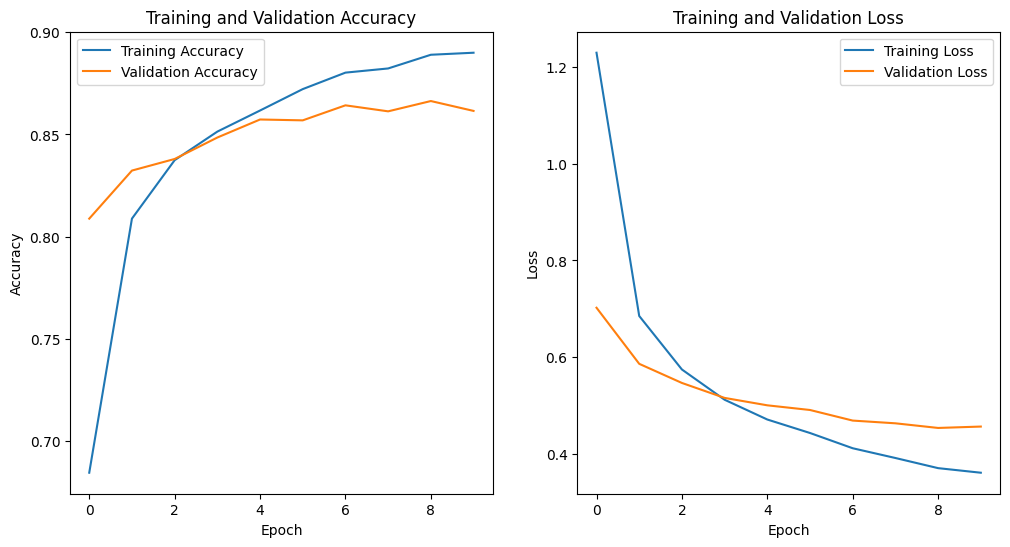

In [ ]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, steps=len(test_data), verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

149/149 ━━━━━━━━━━━━━━━━━━━━ 80s 537ms/step - accuracy: 0.8756 - loss: 0.4433
Test accuracy: 86.40%


In [ ]:
# Choose a subset to test

predicted_classes = []
true_classes = []
#filenames = []
probabilities = []

i = 0
for batch, labels in test_data:
  predictions_batch = model.predict(batch)
  predicted_classes.extend(tf.argmax(predictions_batch, axis=1).numpy())
  true_classes.extend(labels.argmax(axis=1))
  probabilities.extend(predictions_batch)

  #batch_size = batch.shape[0]
  #filenames.extend(test_data.filenames[:batch_size])
  #test_data.filenames = test_data.filenames[batch_size:]

  i += 1
  if i > 10:
    break

predicted_classes = np.array(predicted_classes)
true_classes = np.array(true_classes)
probabilities = np.array(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
# Predicted probability

class_indices = test_data.class_indices
labels_map = {v: k for k, v in class_indices.items()}
actual_labels_names = [labels_map[label] for label in true_classes]
predicted_labels_names = [labels_map[pred] for pred in predicted_classes]

df = pd.DataFrame({
    'Actual': actual_labels_names,
    'Predicted': predicted_labels_names
})

for class_name, class_index in class_indices.items():
  df[f'Prob_{class_name}'] = probabilities[:, class_index]

In [ ]:
df

,Actual,Predicted,Prob_Baked Potato,Prob_Crispy Chicken,Prob_Donut,Prob_Fries,Prob_Hot Dog,Prob_Sandwich,Prob_Taco,Prob_Taquito,...,Prob_kulfi,Prob_masala_dosa,Prob_momos,Prob_omelette,Prob_paani_puri,Prob_pakode,Prob_pav_bhaji,Prob_pizza,Prob_samosa,Prob_sushi
0,Hot Dog,Hot Dog,0.000070,5.171758e-04,2.423119e-03,0.000685,9.729029e-01,3.436179e-03,2.208981e-04,9.553634e-05,...,8.113734e-07,5.226833e-05,9.753259e-08,5.095048e-03,2.464152e-05,8.698314e-06,3.966181e-05,2.845828e-06,6.950801e-07,2.761793e-03
1,ice_cream,ice_cream,0.000158,1.121435e-05,1.137415e-05,0.000004,6.476116e-05,6.562047e-05,7.941676e-05,5.323066e-03,...,2.587024e-06,1.253584e-04,2.823133e-07,6.114086e-05,2.358935e-05,2.738090e-06,1.438338e-03,4.610880e-06,1.192517e-05,1.392872e-03
2,Taquito,Donut,0.000725,1.805482e-04,5.278628e-01,0.010627,2.985227e-02,2.006344e-03,8.342545e-03,3.015069e-01,...,2.826661e-05,1.440514e-05,6.623765e-06,1.159739e-04,6.012714e-03,1.426993e-06,2.373122e-04,3.960459e-04,2.702660e-05,1.322844e-03
3,Hot Dog,Hot Dog,0.000130,4.635515e-06,2.467915e-05,0.000042,9.983723e-01,3.298041e-04,5.615701e-04,2.616659e-04,...,2.113040e-06,2.351554e-06,1.137396e-06,6.927925e-05,2.526570e-05,4.208319e-07,2.759400e-06,1.436210e-06,2.846568e-07,1.356637e-05
4,apple_pie,apple_pie,0.000030,1.871964e-06,2.258221e-07,0.000010,3.414825e-06,2.600274e-06,1.933890e-05,5.499634e-04,...,6.573904e-06,8.578186e-07,1.189223e-05,3.498833e-02,4.286814e-05,9.523573e-05,2.240331e-05,5.239956e-09,1.261365e-02,6.739674e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Sandwich,Sandwich,0.000112,1.975323e-04,3.448728e-05,0.000718,9.720083e-04,9.966967e-01,3.701177e-04,8.609714e-04,...,1.201661e-06,3.970234e-07,1.059369e-11,2.924386e-07,5.231582e-10,8.567841e-09,7.212918e-09,3.132251e-09,2.373605e-09,8.195916e-08
348,chicken_curry,chicken_curry,0.000001,9.914613e-07,1.121257e-08,0.000003,1.068731e-07,1.586025e-07,4.353476e-07,6.173478e-07,...,2.356998e-06,1.476978e-05,1.696534e-06,6.351486e-03,1.331351e-05,4.789792e-07,1.613042e-06,2.884971e-08,3.343820e-07,8.878908e-06
349,dal_makhani,dal_makhani,0.000054,5.721131e-05,2.039613e-07,0.000001,3.225679e-07,1.440000e-05,2.166499e-05,1.080999e-05,...,3.391483e-06,4.308038e-05,3.765738e-07,4.475390e-05,3.936641e-07,1.225833e-06,3.364870e-05,2.296412e-04,2.124039e-07,3.491069e-07
350,Crispy Chicken,Crispy Chicken,0.006993,9.090486e-01,2.283536e-05,0.003417,7.113506e-03,1.521973e-03,4.332981e-03,9.170060e-03,...,4.573409e-06,2.758516e-07,4.710142e-04,1.036228e-03,9.545786e-04,3.611067e-04,3.250248e-03,1.101321e-03,3.592619e-04,5.873040e-04


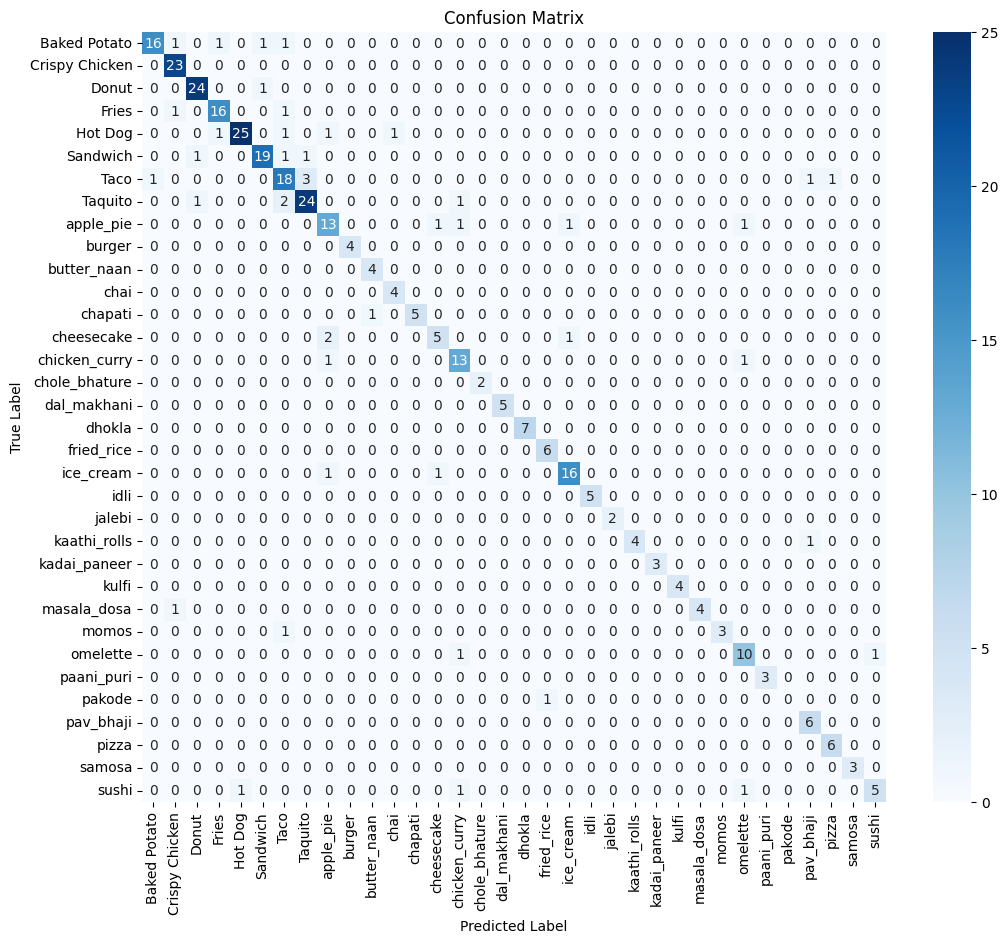

In [ ]:
# Plot the confusion matrix

cf_matrix = confusion_matrix(actual_labels_names, predicted_labels_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save model
model.save('/content/drive/My Drive/AC215_image/food_model_EfficientNet.h5')

In [ ]:
# save test results
df.to_csv('/content/drive/My Drive/AC215_image/predictions_efficientnet.csv', index=True)